# Libraries

In [1]:
from PIL import Image, ImageFilter
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load Images

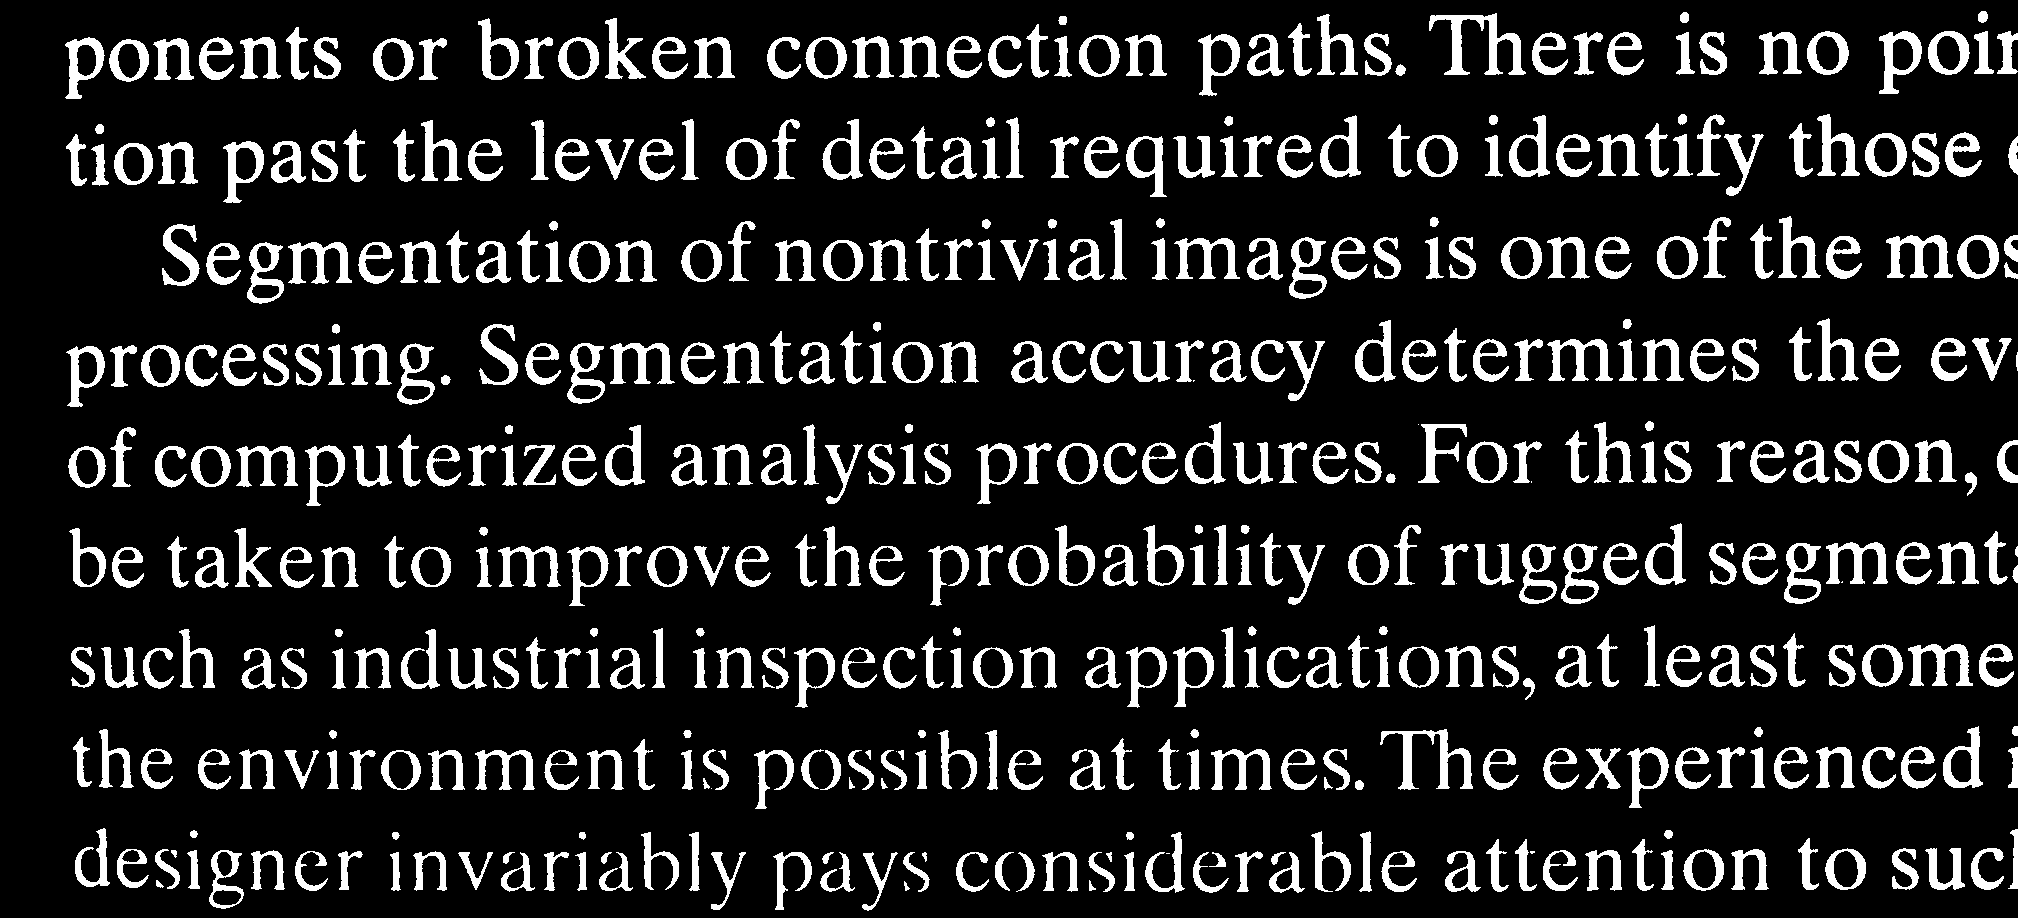

In [2]:
img1 = Image.open('text.tif')
display(img1)

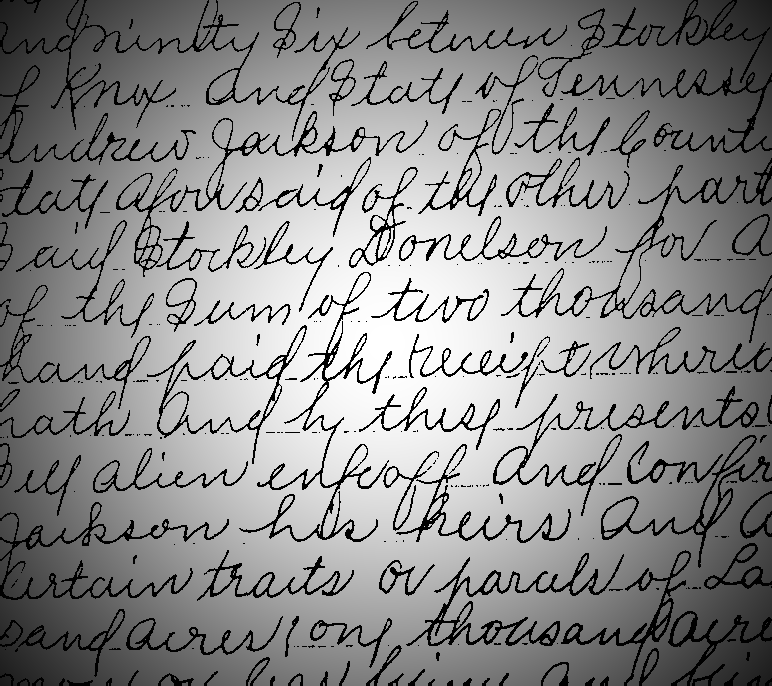

In [3]:
img2 = Image.open('text-spotshade.tif')
display(img2)

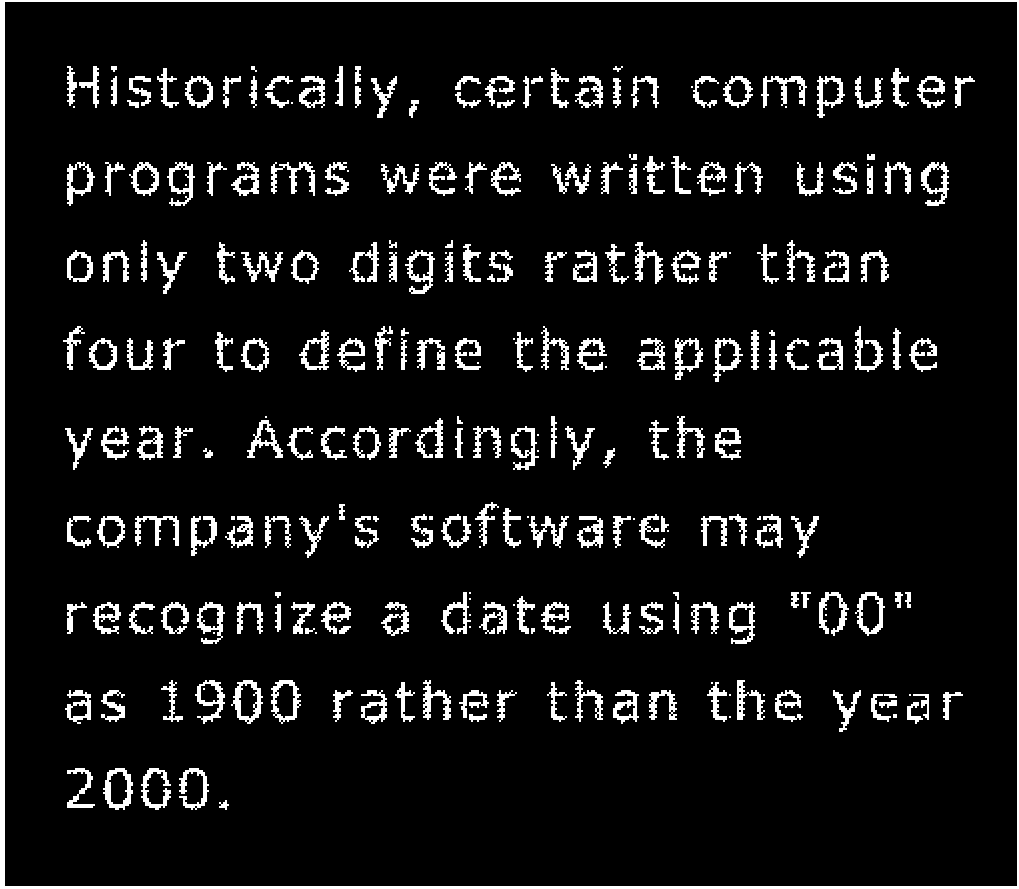

In [4]:
img3 = Image.open('text-broken.tif')
display(img3)

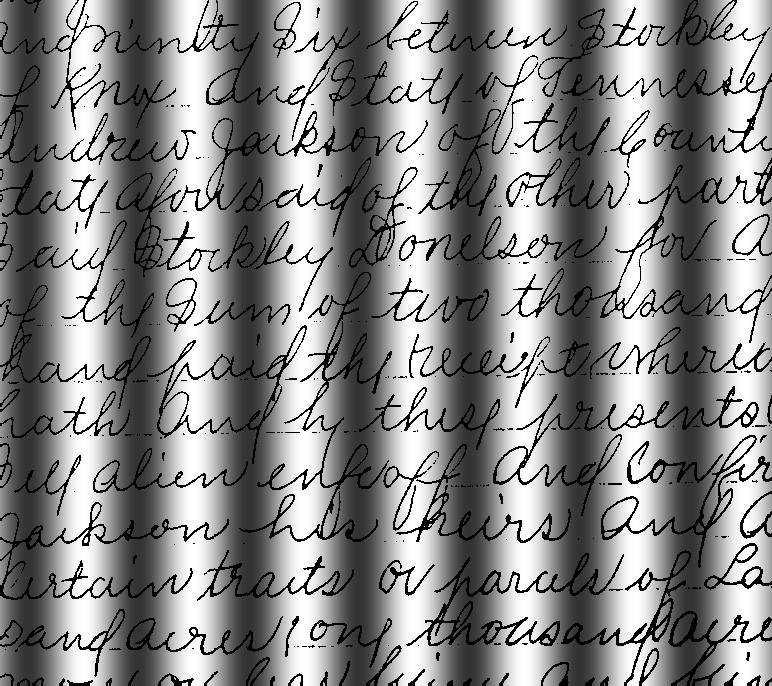

In [5]:
img4 = Image.open('text-sineshade.tif')
display(img4)

# Useful Functions

In [6]:
def ocr(img):
    return pytesseract.image_to_string(img)

def dilate_image(img):
    return img.filter(ImageFilter.MaxFilter(3))

def local_thresholding(img, window_size=20, c=0.5):
    """
    Perform local thresholding using moving averages.

    Parameters:
    img (PIL.Image.Image): Input image.
    window_size (int): Size of the moving window.
    c (float): Constant to adjust the threshold.

    Returns:
    PIL.Image.Image: Thresholded image.
    """
    img_array = np.array(img)
    thresholded_img = np.zeros_like(img_array)

    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            # Define the window boundaries
            i_min = max(i - window_size // 2, 0)
            i_max = min(i + window_size // 2, img_array.shape[0] - 1)
            j_min = max(j - window_size // 2, 0)
            j_max = min(j + window_size // 2, img_array.shape[1] - 1)
            
            # Calculate the local mean
            local_mean = np.mean(img_array[i_min:i_max+1, j_min:j_max+1])
            
            # Apply the threshold with constant c
            if img_array[i, j] > local_mean - c:
                thresholded_img[i, j] = 255
            else:
                thresholded_img[i, j] = 0

    return Image.fromarray(thresholded_img)

def noise_canceling(image, D0=9, n=4, notch_centers=[(0, 0)], padding='origin', 
                    figsize=(10, 10), plot_result=True):
    # Padding
    padded_image = image.copy()
    if padding == 'zero':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_CONSTANT, value=0)
    if padding == 'replicate':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REPLICATE)
    if padding == 'constant':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_CONSTANT, value=255)
    if padding == 'reflect':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REFLECT)
    if padding == 'reflect101':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_REFLECT_101)
    if padding == 'wrap':
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], 
                                          cv2.BORDER_WRAP)
    
    # FFT
    dft = np.fft.fft2(padded_image)
    dft_shifted = np.fft.fftshift(dft)  # Shift the zero frequency component to the center
    magnitude_spectrum = np.log(1 + np.abs(dft_shifted))
    
    # Butterworth Notch Filter
    def butterworth_notch_reject_filter(shape, D0, n, centers):
        rows, cols = shape
        u = np.arange(rows)
        v = np.arange(cols)
        u, v = np.meshgrid(u - rows // 2, v - cols // 2, sparse=False, indexing='ij')
        
        # Initialize filter
        filter_mask = np.ones((rows, cols), dtype=np.float32)
        
        for center in centers:
            D = np.sqrt((u - center[0])**2 + (v - center[1])**2)
            D[D == 0] = 1e-10 # avoid division by zero
            
            D_conj = np.sqrt((u + center[0])**2 + (v + center[1])**2)
            D_conj[D_conj == 0] = 1e-10 # avoid division by zero
            filter_mask *= (1 / (1 + (D0 / D)**n)) * (1 / (1 + (D0 / D_conj)**n))
        
        return filter_mask

    # Create the notch filter mask
    notch_filter = butterworth_notch_reject_filter(dft_shifted.shape, D0, n, notch_centers)

    # Apply the filter in the frequency domain
    filtered_dft = dft_shifted * notch_filter
    filtered_magnitude_spectrum = np.log(1 + np.abs(filtered_dft))
    
    # IFFT
    inverse_shifted = np.fft.ifftshift(filtered_dft)
    img_filtered = np.abs(np.fft.ifft2(inverse_shifted))
     
    # Crop to original image size
    if padding != 'origin':
        original_height, original_width = image.shape
        start_row, start_col = -padded_image.shape[0], 0
        img_filtered = img_filtered[start_row:start_row + original_height, start_col:start_col + original_width]
    
    # Plotting results
    if plot_result:
        plt.figure(figsize=figsize)
        plt.subplot(2, 3, 1), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.axis('off')
        plt.subplot(2, 3, 2), plt.imshow(padded_image, cmap='gray')
        plt.title('Padded Image'), plt.axis('off')
        plt.subplot(2, 3, 3), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Fourier Spectrum'), plt.axis('off')
        plt.subplot(2, 3, 4), plt.imshow(notch_filter, cmap='gray')
        plt.title('Mask Image'), plt.axis('off')
        plt.subplot(2, 3, 5), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
        plt.title('Filtered Spectrum'), plt.axis('off')
        plt.subplot(2, 3, 6), plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered Image'), plt.axis('off')
        plt.show()
    else:
        return img_filtered

In [7]:
text1 = ocr(img1)
print(text1)

ponents or broken connection paths. There is no poi
tion past the level of detail required to identify those

Segmentation of nontrivial images is one of the mo:
processing. Segmentation accuracy determines the ev

of computerized analysis procedures. For this reason, ¢
be taken to improve the probability of rugged segment
such as industrial inspection applications, at least some
the environment is possible at times. The experienced

designer invariably pays considerable attention to suc




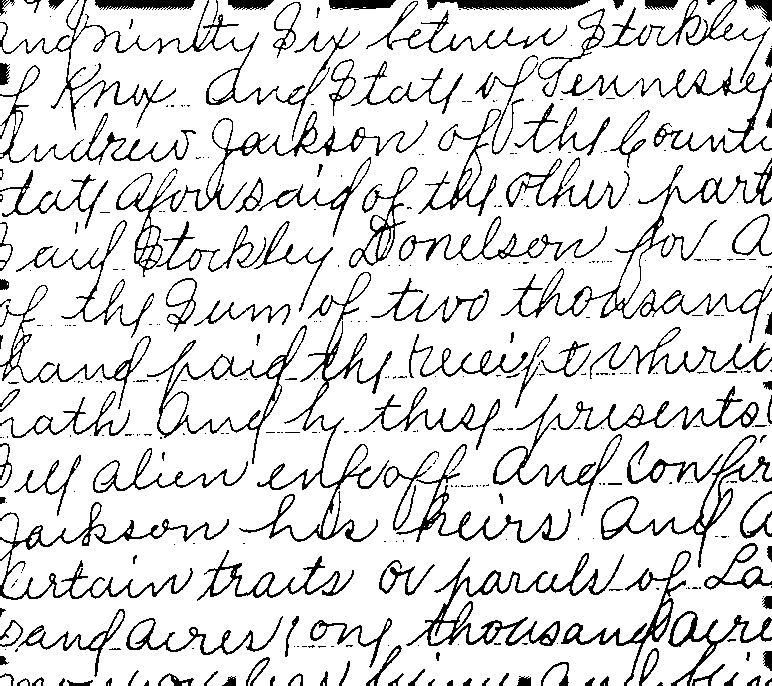

In [8]:
clear_img2 = local_thresholding(img2)
display(clear_img2)

text2 = ocr(clear_img2)
print(text2)

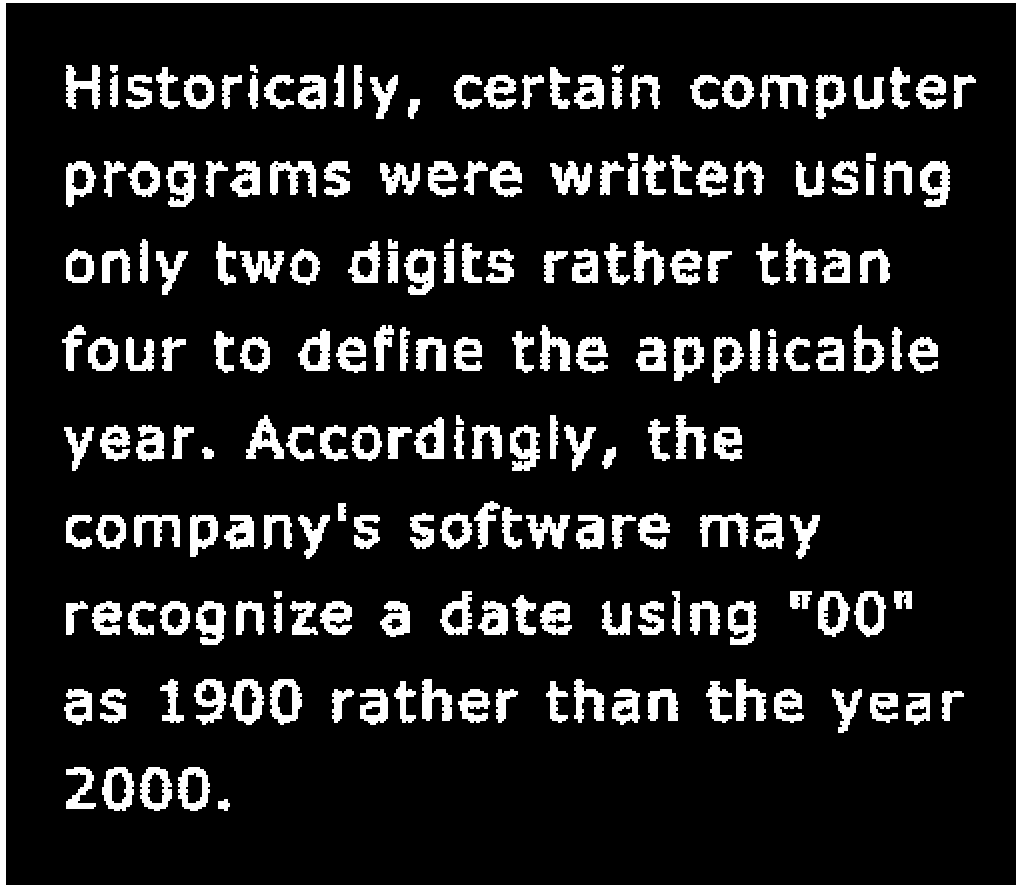

Historically, certain computer
programs were written using
only two digits rather than
four to define the applicable
year. Accordingly, the

company's software may
recognize a date using "00"
as 1900 rather than the year
2000.




In [9]:
dilated_img3 = dilate_image(img3)
display(dilated_img3)

text3 = ocr(dilated_img3)
print(text3)

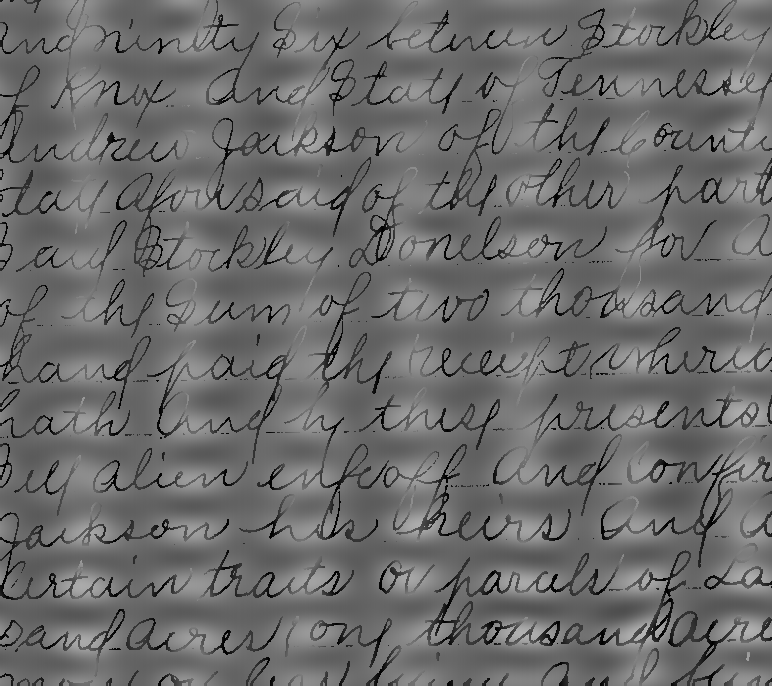

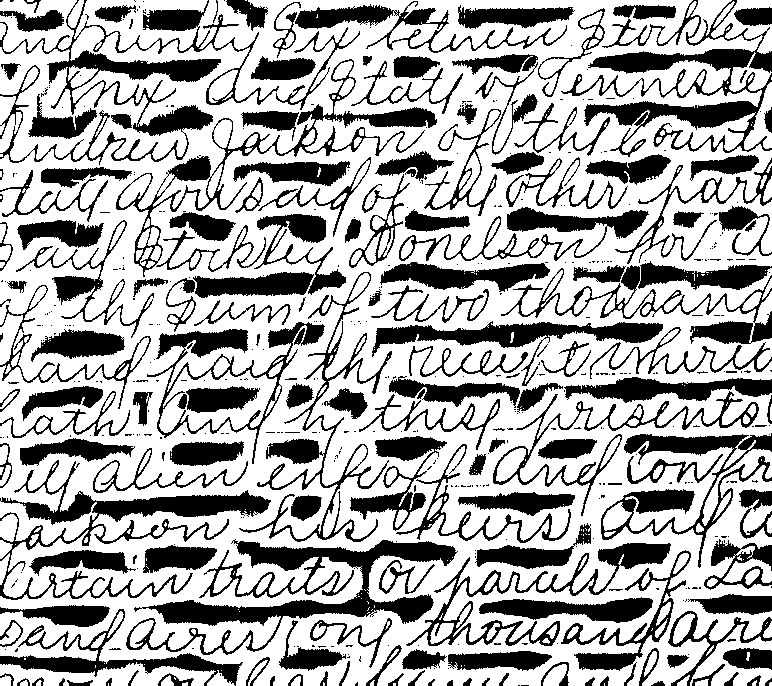

In [ ]:
array_img4 = np.array(img4)

noise_canceled_img4 = noise_canceling(array_img4, notch_centers=[(25, 0), (25, 15), (25, -15), (0, 15)], padding='wrap', figsize=(12, 7), plot_result=False)

corrected_img4 = Image.fromarray(np.uint8(noise_canceled_img4))
display(corrected_img4)

clear_img4 = local_thresholding(corrected_img4)
display(clear_img4)

text4 = ocr(clear_img4)
print(text4)